# II. Pretrained ResNet

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageFile
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout
print(tf.__version__)
import PIL

import time
import numpy as np
import os
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last.
#K.set_learning_phase(1) # 1 stands for learning phase
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

2.16.1


In [21]:
folder_path = '/Users/mingentsai/Desktop/USC/Courses/DSO 569/Homework/Group Project/Bone_Fracture_Binary_Classification'
contents = os.listdir(folder_path)
print(contents)

['.DS_Store', 'test', 'train', 'val']


## 1. Data Preprocessing 
**224*224, RGB**

In [22]:
ImageFile.LOAD_TRUNCATED_IMAGES = True # Allow loading of truncated images

def load_images_from_folder(base_folder):
  data = []
  labels = []
  categories = {'fractured': 1, 'not fractured': 0}
  for category, label in categories.items():
    folder_path = os.path.join(base_folder, category)
    if os.path.isdir(folder_path):
      for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpeg', '.jpg')): # Handle both .jpeg and .jpg fi
          img_path = os.path.join(folder_path, filename)
          try:
            with Image.open(img_path) as img:
              img = img.convert('RGB')
              img = img.resize((224, 224),PIL.Image.Resampling.LANCZOS)
              data.append(np.array(img))
              labels.append(label)
          except IOError as e:
            print(f"Error opening or processing image {img_path}: {e}")
        else:
          print(f"Skipped non-JPEG file {filename}")
    else:
      print(f"Directory {folder_path} does not exist")

  # Convert to numpy arrays
  data = np.array(data)
  labels = np.array(labels)

  # Shuffle the data
  idx = np.arange(len(data))
  np.random.shuffle(idx)
  data = data[idx]
  labels = labels[idx]

  return data, labels

In [23]:
train_data, train_labels = load_images_from_folder(os.path.join(folder_path, 'train'))
val_data, val_labels = load_images_from_folder(os.path.join(folder_path, 'val'))
test_data, test_labels = load_images_from_folder(os.path.join(folder_path, 'test'))

Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store
Skipped non-JPEG file .DS_Store


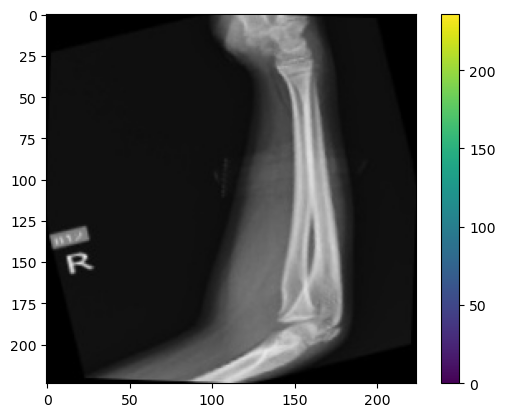

In [24]:
plt.figure()
plt.imshow(train_data[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [25]:
# normalize to range 0-1
train_images = train_data / 255.0
test_images = test_data / 255.0
val_images = val_data / 255.0

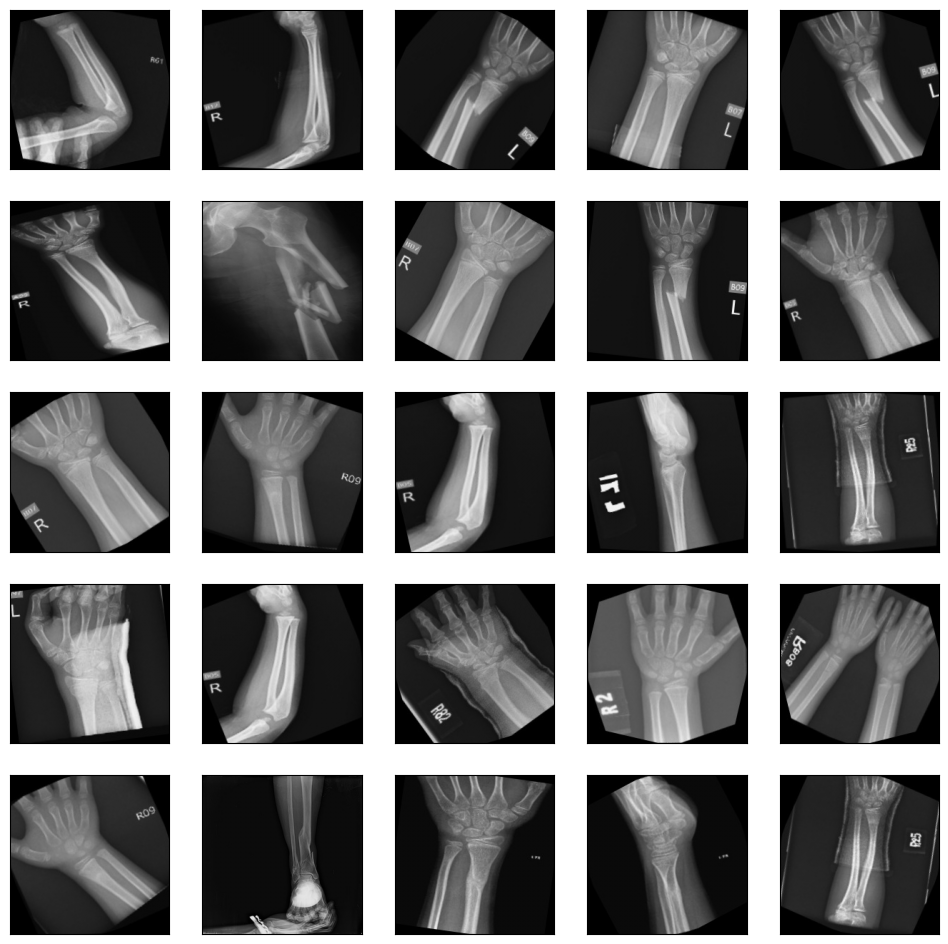

In [26]:
plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical
# Assuming you have two classes, and train_labels are integer labels like [0, 1]
# train_labels= to_categorical(train_labels, num_classes=2)
# test_labels= to_categorical(test_labels, num_classes=2)
# val_labels= to_categorical(val_labels, num_classes=2)

## 2. Model fitting

In [27]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [10]:
#train_images_RGB = np.stack((train_images,train_images,train_images),axis=3)
#test_images_RGB = np.stack((test_images,test_images,test_images),axis=3)
#val_images_RGB = np.stack((val_images,val_images,val_images),axis=3)
#test_images_RGB.shape

(491, 224, 224, 3)

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
# For binary classification, use ‘sigmoid’; for multi-class, use ‘softmax’

In [29]:
model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
model.compile(
    optimizer='adam', # optimizer
    loss='binary_crossentropy', # loss function to optimize
    metrics=['accuracy'] # metrics to monitor
)

In [31]:
callbacks_list = [
    #tf.keras.callbacks.EarlyStopping(
        #monitor="val_accuracy",
        #patience=2,),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]



history = model.fit(train_images,  train_labels, epochs=10,
          batch_size=64, validation_data=(val_images, val_labels),
          callbacks=callbacks_list)

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 843s 6s/step - accuracy: 0.8662 - loss: 0.3728 - val_accuracy: 0.5925 - val_loss: 1.3040
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 820s 6s/step - accuracy: 0.9739 - loss: 0.0850 - val_accuracy: 0.5925 - val_loss: 0.6833
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 814s 6s/step - accuracy: 0.9895 - loss: 0.0345 - val_accuracy: 0.5925 - val_loss: 0.8066
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 799s 6s/step - accuracy: 0.9972 - loss: 0.0097 - val_accuracy: 0.3736 - val_loss: 0.6957
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 820s 6s/step - accuracy: 0.9884 - loss: 0.0337 - val_accuracy: 0.4208 - val_loss: 0.9673
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 807s 6s/step - accuracy: 0.9966 - loss: 0.0091 - val_accuracy: 0.6288 - val_loss: 0.9960
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - accuracy: 1.0000 - loss: 8.0597e-04 - val_accuracy: 0.7497 - val_loss: 1.1062
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - accuracy: 1.0000 - loss: 3.4829e-04 - 

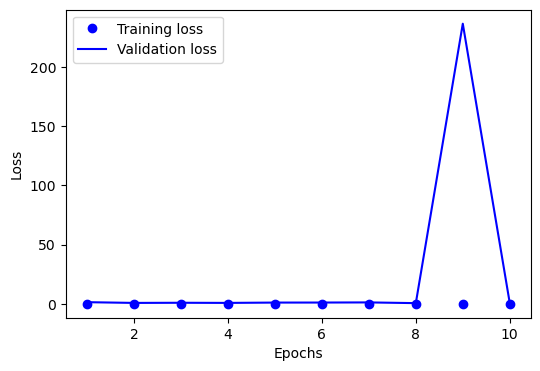

In [32]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
# Set up the range of epochs
epochs = range(1, len(loss_values) + 1)
# Create a plot of the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_values, 'bo', label='Training loss') # 'bo' for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # 'b' for solid blue line plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
model_best = keras.models.load_model("checkpoint_path.keras")
test_loss, test_acc = model_best.evaluate(test_images_RGB, test_labels)
print("Test accuracy:", test_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 584ms/step - accuracy: 0.4553 - loss: 4.4207
Test accuracy: 0.48472505807876587
